# 📌 Detecção de Transações Fraudulentas
**Objetivo:** Desenvolver um modelo que prevê se uma transação é fraudulenta.

**Modelos Utilizados:**
- KNN
- Árvore de Decisão
- Regressão Logística



In [ ]:

# 📌 1. Importação das Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV





In [ ]:

# 📌 2. Carregamento dos Dados
df = pd.read_csv("fraud_dataset.csv")

# Visualização das primeiras linhas
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  69858.000000  6.985800e+04   6.985800e+04    6.985800e+04   
mean       7.893326  1.640176e+05   9.043066e+05    9.202980e+05   
std        1.874512  3.313730e+05   2.791616e+06    2.829881e+06   
min        1.000000  6.300000e-01   0.000000e+00    0.000000e+00   
25%        8.000000  9.011012e+03   0.000000e+00    0.000000e+00   
50%        8.000000  4.404918e+04   1.990850e+04    0.000000e+00   
75%        9.000000  1.991307e+05   1.721175e+05    1.940205e+05   
max        9.000000  1.000000e+07   3.379739e+07    3.400874e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.985800e+04    6.985700e+04  69857.000000         69857.0  
mean     8.543

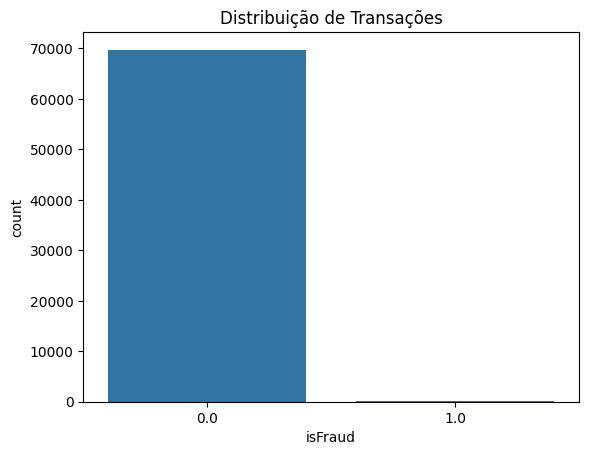

In [ ]:

# 📌 3. Análise Exploratória dos Dados
# Verificando valores nulos
print(df.isnull().sum())

# Estatísticas básicas
print(df.describe())

# Distribuição de transações fraudulentas vs não fraudulentas
sns.countplot(x='isFraud', data=df)
plt.title("Distribuição de Transações")
plt.show()


In [ ]:

# 📌 4. Pré-processamento dos Dados
# Removendo colunas irrelevantes
df = df.drop(["nameOrig", "nameDest"], axis=1)

# Codificação one-hot para features categóricas
df = pd.get_dummies(df, columns=['type'], drop_first=True)  # Assume que 'type' tem valores como 'PAYMENT'

# Removendo valores ausentes na variável-alvo antes da normalização
df = df.dropna(subset=["isFraud"])  # Remove linhas onde 'isFraud' é NaN

# Normalizando os dados
scaler = StandardScaler()
# Seleciona apenas as colunas numéricas, exceto a variável-alvo
numerical_features = df.select_dtypes(include=np.number).columns.difference(['isFraud'])
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)

# Adicionando a variável alvo e colunas codificadas por one-hot de volta
df_scaled = pd.concat([df_scaled, df[['isFraud'] + list(df.columns.difference(numerical_features).difference(['isFraud']))]], axis=1)

# Separando features e target
X = df_scaled.drop("isFraud", axis=1)
y = df_scaled["isFraud"]

# Divisão em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 📌 5. Aplicando SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:

# 📌 6. Treinamento dos Modelos Balanceados

# 🔹 Definição dos modelos com ajuste de pesos para desbalanceamento
modelos_balanceados = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Regressão Logística": LogisticRegression(class_weight="balanced")
}

# 🔹 Treinamento e Previsão com dados balanceados
y_preds_balanceados = {}

for nome, modelo in modelos_balanceados.items():
    modelo.fit(X_resampled, y_resampled)
    y_preds_balanceados[nome] = modelo.predict(X_test)


In [ ]:
# 📌 7. Função para Avaliação dos Modelos
def avaliar_modelo(nome, y_true, y_pred):
    print(f"\n🔍 Avaliação do modelo: {nome}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    # Exibe visualmente a matriz de confusão
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusão - {nome}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()


📌 Avaliação dos Modelos com Dados Balanceados:

🔍 Avaliação do modelo: KNN
Accuracy: 0.9874033781849413
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     13953
         1.0       0.06      0.53      0.10        19

    accuracy                           0.99     13972
   macro avg       0.53      0.76      0.55     13972
weighted avg       1.00      0.99      0.99     13972

Confusion Matrix:
 [[13786   167]
 [    9    10]]


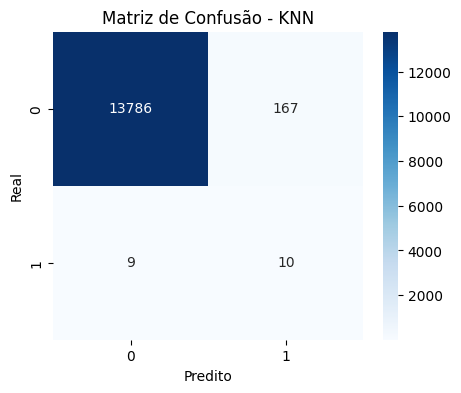


🔍 Avaliação do modelo: Árvore de Decisão
Accuracy: 0.9976381334096764
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13953
         1.0       0.32      0.63      0.42        19

    accuracy                           1.00     13972
   macro avg       0.66      0.81      0.71     13972
weighted avg       1.00      1.00      1.00     13972

Confusion Matrix:
 [[13927    26]
 [    7    12]]


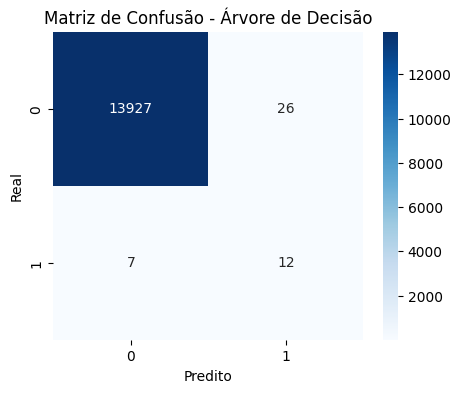


🔍 Avaliação do modelo: Regressão Logística
Accuracy: 0.9346550243343831
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.93      0.97     13953
         1.0       0.02      0.95      0.04        19

    accuracy                           0.93     13972
   macro avg       0.51      0.94      0.50     13972
weighted avg       1.00      0.93      0.96     13972

Confusion Matrix:
 [[13041   912]
 [    1    18]]


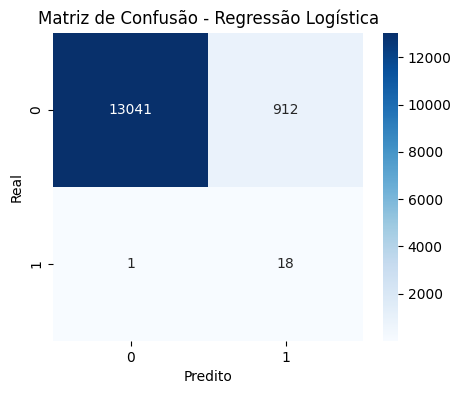

In [ ]:

# 📌 8. Avaliação dos Modelos Balanceados

print("\n📌 Avaliação dos Modelos com Dados Balanceados:")
for nome, y_pred in y_preds_balanceados.items():
    avaliar_modelo(nome, y_test, y_pred)


📌 Importância das Features:
           Feature  Importance
6             step    0.366764
5    oldbalanceOrg    0.139534
10   type_TRANSFER    0.103634
9     type_PAYMENT    0.092155
4   oldbalanceDest    0.081099
7    type_CASH_OUT    0.075449
3   newbalanceOrig    0.064289
0           amount    0.063577
2   newbalanceDest    0.012267
8       type_DEBIT    0.001232
1   isFlaggedFraud    0.000000


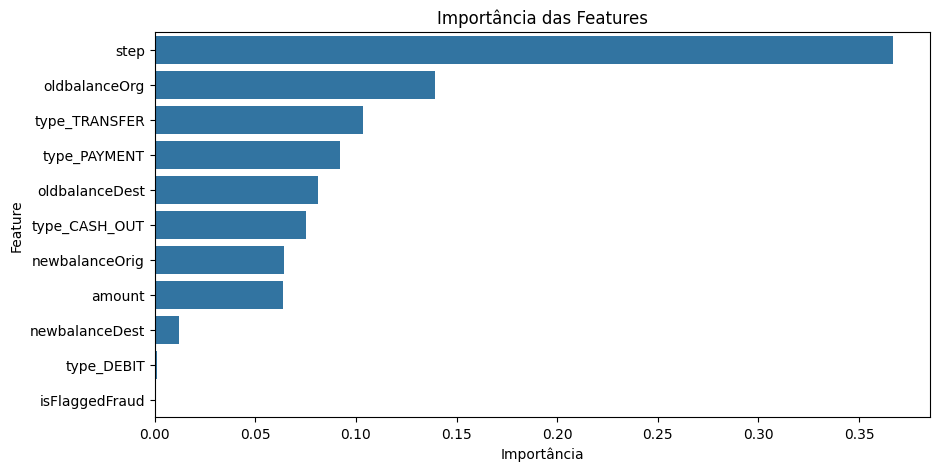

In [ ]:

# 📌 9. Seleção de Features Importantes

# Pegando a importância das features da Árvore de Decisão treinada
importances = modelos_balanceados["Árvore de Decisão"].feature_importances_


# Criando um DataFrame com as importâncias das features
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
})

# Ordenando do mais importante para o menos importante
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Exibindo as principais features
print("\n📌 Importância das Features:")
print(feature_importance_df)

# Gráfico de barras para visualização
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"])
plt.title("Importância das Features")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.show()


🔎 Otimizando KNN com GridSearchCV...
Melhores parâmetros para KNN: {'n_neighbors': 3, 'weights': 'distance'}

🔎 Otimizando Árvore de Decisão com GridSearchCV...
Melhores parâmetros para Árvore de Decisão: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2}

🔎 Otimizando Regressão Logística com GridSearchCV...
Melhores parâmetros para Regressão Logística: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}

📌 Avaliação dos Modelos Otimizados:

🔍 Avaliação do modelo: KNN
Accuracy: 0.9908388204981391
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     13953
         1.0       0.08      0.53      0.14        19

    accuracy                           0.99     13972
   macro avg       0.54      0.76      0.57     13972
weighted avg       1.00      0.99      0.99     13972

Confusion Matrix:
 [[13834   119]
 [    9    10]]


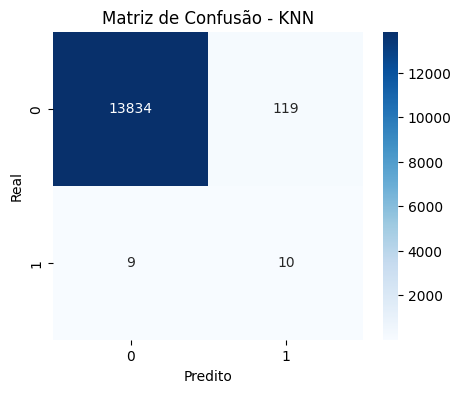


🔍 Avaliação do modelo: Árvore de Decisão
Accuracy: 0.9976381334096764
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13953
         1.0       0.32      0.63      0.42        19

    accuracy                           1.00     13972
   macro avg       0.66      0.81      0.71     13972
weighted avg       1.00      1.00      1.00     13972

Confusion Matrix:
 [[13927    26]
 [    7    12]]


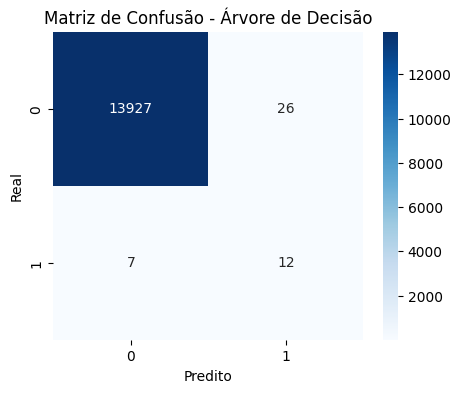


🔍 Avaliação do modelo: Regressão Logística
Accuracy: 0.9448897795591182
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     13953
         1.0       0.02      0.95      0.04        19

    accuracy                           0.94     13972
   macro avg       0.51      0.95      0.51     13972
weighted avg       1.00      0.94      0.97     13972

Confusion Matrix:
 [[13184   769]
 [    1    18]]


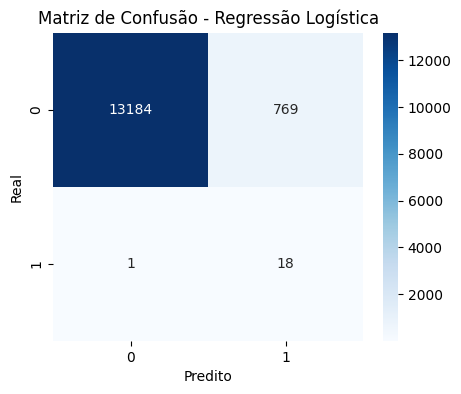

In [ ]:

# 📌 10. Ajuste e Melhoria dos Modelos

# Definição dos Hiperparâmetros para GridSearchCV
parametros = {
    "KNN": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"]
    },
    "Árvore de Decisão": {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "class_weight": ["balanced"]
    },
    "Regressão Logística": {
        "C": [0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear"]
    }
}

# Aplicando GridSearchCV
melhores_modelos = {}

for nome, modelo in modelos_balanceados.items():
    print(f"\n🔎 Otimizando {nome} com GridSearchCV...")

    grid_search = GridSearchCV(
        modelo,
        parametros[nome],
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )

    grid_search.fit(X_resampled, y_resampled)

    melhores_modelos[nome] = grid_search.best_estimator_
    print(f"Melhores parâmetros para {nome}: {grid_search.best_params_}")

# Avaliação dos Modelos Otimizados
print("\n📌 Avaliação dos Modelos Otimizados:")
y_preds_otimizados = {}

for nome, modelo in melhores_modelos.items():
    y_preds_otimizados[nome] = modelo.predict(X_test)
    avaliar_modelo(nome, y_test, y_preds_otimizados[nome])


# 📊 Conclusão da Avaliação dos Modelos

Após otimizar os hiperparâmetros via **GridSearchCV**, avaliamos três modelos: **KNN, Árvore de Decisão e Regressão Logística**. Abaixo está um resumo das métricas de desempenho:

| Modelo                | Accuracy | Precision (1) | Recall (1) | F1-score (1) |
|-----------------------|----------|--------------|------------|-------------|
| **KNN**              | 99.08%   | 8%           | 53%        | 14%         |
| **Árvore de Decisão** | 99.76%   | 32%          | 63%        | 42%         |
| **Regressão Logística** | 94.48%   | 2%           | 95%        | 4%          |

## 🔍 Principais observações:
- **Árvore de Decisão** teve **melhor equilíbrio** entre precisão e recall para a classe fraudulenta (1), tornando-se a opção mais viável.
- **Regressão Logística** alcançou **alto recall (95%)**, ou seja, identificou quase todas as fraudes, mas sua precisão foi muito baixa (2%).
- **KNN teve a menor performance**, pois o recall foi **apenas 53%**, perdendo quase metade das fraudes.

---

## 📉 Visualização das Matrizes de Confusão

Podemos visualizar o desempenho de cada modelo com as matrizes de confusão:

```python
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Dados das Matrizes de Confusão
models = {
    "KNN": np.array([[13834, 119], [9, 10]]),
    "Árvore de Decisão": np.array([[13927, 26], [7, 12]]),
    "Regressão Logística": np.array([[13184, 769], [1, 18]])
}

# Criando os gráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (model, cm) in zip(axes, models.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"Matriz de Confusão - {model}")
    ax.set_xlabel("Predito")
    ax.set_ylabel("Real")

plt.show()
